## Import packages and load data

In [ ]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Data/"
data = pd.read_csv(data_path+"new_data_cleaned_sample.csv")

In [ ]:
data.head()

,Unnamed: 0,email_id,subject,email,bow,embeddings
0,0,taylor-m\all_documents\3696#1,ETS Risk Assessment Reporting Memorandum,taylor-m\all_documents\3696,dear discussed attached please find memorandum...,"dear al: discussed, attached please find memor..."
1,1,sanchez-m\deleted_items\7#1,prebon/ene dinner,sanchez-m\deleted_items\7,guy know past week asking guy could come prebo...,guys...i know past week asking guy could come ...
2,2,white-s\deleted_items\616#1,ERV Notification: (West Power Desk Daily Pric...,white-s\deleted_items\616,report named west power desk daily price repor...,report named: west power desk daily price repo...
3,3,hyatt-k\enron_kids\6#1,Conference Room Reservations,hyatt-k\enron_kids\6,need schedule mega conference room enron kid m...,need schedule mega conference room enron kid m...
4,4,germany-c\all_documents\1696#1,Iroq parking deal,germany-c\all_documents\1696,gang fairly certain entered parking deal wrong...,gang. i'm fairly certain entered parking deal ...


## LDA

In [ ]:
if type(data['bow']) is list:
    text = data['bow']
else:
    text = data['bow'].tolist()
# t = []
# for x in text:
#   temp = []
#   for a in str(x).split():
#     if a not in ['imagemasker','urlmasker','tofrom','namemasker','im','smith','john','pm','please']:
#       temp.append(a)
#   t.append(temp)
# text = t
text=[str(x).split() for x in text]

In [ ]:
id2word = corpora.Dictionary(text)
# Create Corpus
texts = text
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
num_topics = 7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## Topic evolution

### Get an email with threads

In [ ]:
data[['email','id']] = data['email_id'].str.split('#',1,expand = True)
df = data['email'].value_counts()
df = df.reset_index()
thread = data.merge(df,left_on = 'email',right_on = 'index')
thread = thread[thread['email_y']>1]
thread = thread.sort_values('email_y')
thread['id'] = thread['id'].map(int)

### Averaged topic probability

In [ ]:
probability = []
for i in doc_lda:
  a = [0]*num_topics
  for x in i[0]:
    a[x[0]] = x[1]
  probability.append(np.array(a))
probs = np.array(probability)

In [ ]:
sample_30 = pd.read_csv(data_path+'30_selected_samples.csv')

In [ ]:
def get_new_topics(email_id):
  threads = thread[thread['email_x'] == email_id].sort_values('id')
  result = []
  topic_evolv = []
  topic_origin = []
  frequency = {}
  for i in range(len(threads)):
    body = threads['bow'].iloc[i].split()
    weight = min(1,1/(np.log(len(body)+1)+1)*2)
    if i==0:
      topic_evolv.append(str(np.argmax(probs[threads.index[i]])))
      topic_origin.append(str(np.argmax(probs[threads.index[i]])))
      result.append(probs[threads.index[i]])
    else:
      result.append((weight)*result[-1]+(1-weight)*probs[threads.index[i]])
      topic_evolv.append(str(np.argmax(result[-1])))
      topic_origin.append(str(np.argmax(probs[threads.index[i]])))
    if topic_evolv[-1] in frequency:
      frequency[topic_evolv[-1]]+=1
    else:
      frequency[topic_evolv[-1]] = 1
  return topic_evolv, frequency, threads, topic_origin

In [ ]:
# for the purpose of being consistent with the lda result from R
topic_dic = {0:1,
1:3,
2:6,
3:7,
4:4,
5:2,
6:5
}

In [ ]:
topic_evolv, frequency, threads, topic_origin = get_new_topics(sample_30.iloc[20].email)

In [ ]:
# show all the topics and their corresponding words
for j in range(7):
  topic_word = [str(j)]
  for i in lda_model.get_topic_terms(int(j),10):
    topic_word.append(id2word.id2token[i[0]])
  print('_'.join(topic_word))

0_company_enron_new_energy_million_year_trading_market_service_cost
1_please_said_enron_may_information_agreement_business_contract_attached_mail
2_enron_com_houston_employee_team_thursday_davis_business_skadden_generation
3_san_understand_travel_vacation_earlier_coming_hotel_station_fare_diego
4_would_know_need_time_let_get_like_deal_meeting_call
5_urlmasker_way_one_going_new_year_free_make_still_imagemasker
6_power_state_market_price_gas_california_energy_utility_customer_rate


### Some visualizations

In [ ]:
import seaborn as sns
sns. set (style= "darkgrid")

In [ ]:
thread_change = {}
topic_change_per_email = {}
topic_transition = [[0 for i in range(num_topics)] for j in range(num_topics)]
length = []
topic_change_num = []
lag = 3  # given topic at time t-lag, what is topic at time t
for ind in set(list(thread.email_x)):
  topic_evolv, frequency, threads, topic_origin = get_new_topics(ind)
  num = 0
  count = 1
  for i in range(len(topic_evolv)-lag):
    topic_transition[int(topic_evolv[i])][int(topic_evolv[i+lag])]+=1
    if topic_evolv[i]==topic_evolv[i+lag]:
      count += 1
    else:
      num+=1
      if count in thread_change:
        thread_change[count]+=1
      else:
        thread_change[count]=1
      count = 1
  if num in topic_change_per_email:
    topic_change_per_email[num]+=1
  else:
    topic_change_per_email[num] = 1
  length.append(len(threads))
  topic_change_num.append(num)

#### Directed Graph

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()

In [ ]:
edge = []
for i in range(len(topic_transition)):
  for j in range(len(topic_transition)):
    if topic_transition[i][j]<10:
      continue
    edge.append((i,j,topic_transition[i][j]))

In [ ]:
G.add_weighted_edges_from(edge)

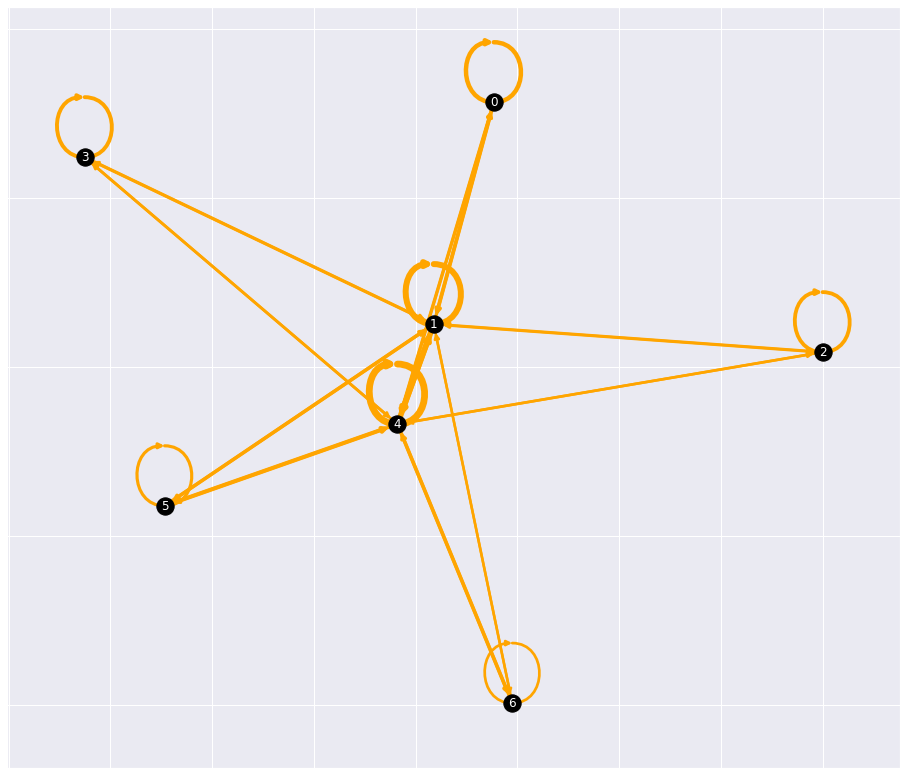

In [ ]:
pos = nx.spring_layout(G, iterations=20)
plt.figure(figsize=(16,14))
nx.draw_networkx_edges(G,pos, width=[np.log(d['weight'])*0.5 for (u,v,d) in G.edges(data=True)], edge_color="orange")
nx.draw_networkx_nodes(G,pos, node_color="black")
nx.draw_networkx_labels(G, pos, font_color="white")
plt.show()

# nx.draw(G,
#     with_labels=True,
#     pos = nx.sprint_layout(G),
#     node_color=color_list,
#     edge_color='k',
#     node_size=100,
#     node_shape='o',
#     linewidths=2,
#     width=1.0,
#     alpha=0.55,
#     style='solid',
#     font_size=9,
#     font_color='k'
# )


#### Transition heatmap

In [ ]:
topic_transition_log = [[0 for i in range(num_topics)] for j in range(num_topics)]
topic_transition_new = [[0 for i in range(num_topics)] for j in range(num_topics)]
for i in range(len(topic_transition)):
  for j in range(len(topic_transition)):
    topic_transition_log[topic_dic[i]-1][topic_dic[j]-1] = round(np.log(topic_transition[i][j]+1))
    topic_transition_new[topic_dic[i]-1][topic_dic[j]-1] = topic_transition[i][j]

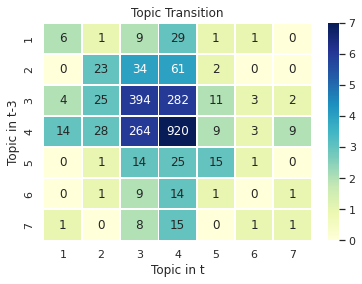

In [ ]:
s = sns.heatmap(topic_transition_log,annot=topic_transition_new, fmt="d", cmap="YlGnBu", linewidths=.6)
s.set(xlabel='Topic in t', ylabel='Topic in t-3',title = 'Topic Transition',xticklabels = list(range(1,8)),yticklabels = list(range(1,8)));

#### Number of topic changes per email vs length

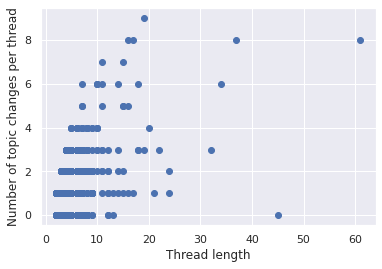

In [ ]:
plt.scatter(length,topic_change_num)
# plt.title('Number of topic changes per email vs length')
plt.ylabel('Number of topic changes per thread')
plt.xlabel('Thread length');

#### Number of topic changes per email

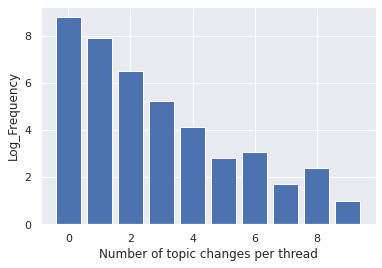

In [ ]:
x, y = zip (*sorted(topic_change_per_email.items(),key = lambda x:x[1],reverse = True))
plt.bar(x,np.log(y)+1)
# plt.title('Number of topic changes per thread')
plt.ylabel('Log_Frequency')
plt.xlabel('Number of topic changes per thread');

#### Frequency of thread length when topic changes

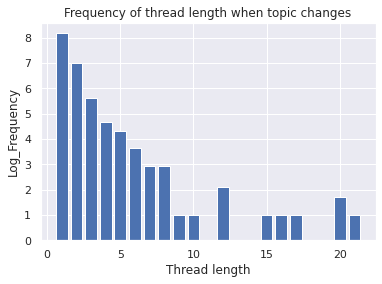

In [ ]:
x, y = zip (*sorted(thread_change.items(),key = lambda x:x[1],reverse = True))
plt.bar(x,np.log(y)+1)
plt.title('Frequency of thread length when topic changes')
plt.ylabel('Log_Frequency')
plt.xlabel('Thread length');

## Evolution visualization

In [ ]:
topic_evolv, frequency, threads, topic_origin = get_new_topics(sample_30.iloc[20].email)

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### pyLDAvis code change

In [ ]:
"""
pyLDAvis Prepare
===============
Main transformation functions for preparing LDAdata to the visualization's data structures
"""

from past.builtins import basestring
from collections import namedtuple
import json
import logging
from joblib import Parallel, delayed, cpu_count
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from pyLDAvis.utils import NumPyEncoder
try:
    from sklearn.manifold import MDS, TSNE
    sklearn_present = True
except ImportError:
    sklearn_present = False


def __num_dist_rows__(array, ndigits=2):
    return array.shape[0] - int((pd.DataFrame(array).sum(axis=1) < 0.999).sum())


class ValidationError(ValueError):
    pass


def _input_check(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency):
    ttds = topic_term_dists.shape
    dtds = doc_topic_dists.shape
    errors = []

    def err(msg):
        errors.append(msg)

    if dtds[1] != ttds[0]:
        err_msg = ('Number of rows of topic_term_dists does not match number of columns of '
                   'doc_topic_dists; both should be equal to the number of topics in the model.')
        err(err_msg)

    if len(doc_lengths) != dtds[0]:
        err_msg = ('Length of doc_lengths not equal to the number of rows in doc_topic_dists;'
                   'both should be equal to the number of documents in the data.')
        err(err_msg)

    W = len(vocab)
    if ttds[1] != W:
        err_msg = ('Number of terms in vocabulary does not match the number of columns of '
                   'topic_term_dists (where each row of topic_term_dists is a probability '
                   'distribution of terms for a given topic)')
        err(err_msg)
    if len(term_frequency) != W:
        err_msg = ('Length of term_frequency not equal to the number of terms in the '
                   'number of terms in the vocabulary (len of vocab)')
        err(err_msg)

    if __num_dist_rows__(topic_term_dists) != ttds[0]:
        err('Not all rows (distributions) in topic_term_dists sum to 1.')

    if __num_dist_rows__(doc_topic_dists) != dtds[0]:
        err('Not all rows (distributions) in doc_topic_dists sum to 1.')

    if len(errors) > 0:
        return errors


def _input_validate(*args):
    res = _input_check(*args)
    if res:
        raise ValidationError('\n' + '\n'.join([' * ' + s for s in res]))


def _jensen_shannon(_P, _Q):
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))


def _pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)

    return np.sqrt(eigvals) * eigvecs


def js_PCoA(distributions):
    """Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis
    (aka Classical Multidimensional Scaling)

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    Returns
    -------
    pcoa : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    return _pcoa(dist_matrix)


def js_MMDS(distributions, **kwargs):
    """Dimension reduction via Jensen-Shannon Divergence & Metric Multidimensional Scaling

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    **kwargs : Keyword argument to be passed to `sklearn.manifold.MDS()`

    Returns
    -------
    mmds : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    model = MDS(n_components=2, random_state=0, dissimilarity='precomputed', **kwargs)
    return model.fit_transform(dist_matrix)


def js_TSNE(distributions, **kwargs):
    """Dimension reduction via Jensen-Shannon Divergence & t-distributed Stochastic Neighbor Embedding

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    **kwargs : Keyword argument to be passed to `sklearn.manifold.TSNE()`

    Returns
    -------
    tsne : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    model = TSNE(n_components=2, random_state=0, metric='precomputed', **kwargs)
    return model.fit_transform(dist_matrix)


def _df_with_names(data, index_name, columns_name):
    if type(data) == pd.DataFrame:
        # we want our index to be numbered
        df = pd.DataFrame(data.values)
    else:
        df = pd.DataFrame(data)
    df.index.name = index_name
    df.columns.name = columns_name
    return df


def _series_with_name(data, name):
    if type(data) == pd.Series:
        data.name = name
        # ensures a numeric index
        return data.reset_index()[name]
    else:
        return pd.Series(data, name=name)


def _topic_coordinates(mds, topic_term_dists, topic_proportion, start_index=1):
    K = topic_term_dists.shape[0]
    mds_res = mds(topic_term_dists)
    assert mds_res.shape == (K, 2)
    mds_df = pd.DataFrame({'x': mds_res[:, 0], 'y': mds_res[:, 1],
                          #  'topics': range(start_index, K + start_index),
                           'cluster': 1, 'Freq': topic_proportion * 100})
    # note: cluster (should?) be deprecated soon. See: https://github.com/cpsievert/LDAvis/issues/26
    mds_df['topics'] = mds_df.index
    return mds_df


def _chunks(lambda_seq, n):
    """ Yield successive n-sized chunks from lambda_seq.
    """
    for i in range(0, len(lambda_seq), n):
        yield lambda_seq[i:i + n]


def _job_chunks(lambda_seq, n_jobs):
    n_chunks = n_jobs
    if n_jobs < 0:
        # so, have n chunks if we are using all n cores/cpus
        n_chunks = cpu_count() + 1 - n_jobs

    return _chunks(lambda_seq, n_chunks)


def _find_relevance(log_ttd, log_lift, R, lambda_):
    relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift
    return relevance.T.apply(lambda topic: topic.nlargest(R).index)


def _find_relevance_chunks(log_ttd, log_lift, R, lambda_seq):
    return pd.concat([_find_relevance(log_ttd, log_lift, R, seq) for seq in lambda_seq])


def _topic_info(topic_term_dists, topic_proportion, term_frequency, term_topic_freq,
                vocab, lambda_step, R, n_jobs, start_index=1):
    # marginal distribution over terms (width of blue bars)
    term_proportion = term_frequency / term_frequency.sum()

    # compute the distinctiveness and saliency of the terms:
    # this determines the R terms that are displayed when no topic is selected.
    tt_sum = topic_term_dists.sum()
    topic_given_term = pd.eval("topic_term_dists / tt_sum")
    log_1 = np.log(pd.eval("topic_given_term.T / topic_proportion"))
    kernel = pd.eval("topic_given_term * log_1.T")
    distinctiveness = kernel.sum()
    saliency = term_proportion * distinctiveness
    # Order the terms for the "default" view by decreasing saliency:
    default_term_info = pd.DataFrame({
        'saliency': saliency,
        'Term': vocab,
        'Freq': term_frequency,
        'Total': term_frequency,
        'Category': 'Default'})
    default_term_info = default_term_info.sort_values(
        by='saliency', ascending=False).head(R).drop('saliency', 1)
    # Rounding Freq and Total to integer values to match LDAvis code:
    default_term_info['Freq'] = np.floor(default_term_info['Freq'])
    default_term_info['Total'] = np.floor(default_term_info['Total'])
    ranks = np.arange(R, 0, -1)
    default_term_info['logprob'] = default_term_info['loglift'] = ranks
    default_term_info = default_term_info.reindex(columns=[
        "Term", "Freq", "Total", "Category", "logprob", "loglift"
    ])

    # compute relevance and top terms for each topic
    log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
    log_ttd = np.log(pd.eval("topic_term_dists")).astype("float64")
    lambda_seq = np.arange(0, 1 + lambda_step, lambda_step)

    def topic_top_term_df(tup):
        new_topic_id, (original_topic_id, topic_terms) = tup
        term_ix = topic_terms.unique()
        df = pd.DataFrame({'Term': vocab[term_ix],
                           'Freq': term_topic_freq.loc[original_topic_id, term_ix],
                           'Total': term_frequency[term_ix],
                           'Category': 'Topic%d' % new_topic_id,
                           'logprob': log_ttd.loc[original_topic_id, term_ix].round(4),
                           'loglift': log_lift.loc[original_topic_id, term_ix].round(4),
                           })
        return df.reindex(columns=[
            "Term", "Freq", "Total", "Category", "logprob", "loglift"
        ])

    top_terms = pd.concat(Parallel(n_jobs=n_jobs)
                          (delayed(_find_relevance_chunks)(log_ttd, log_lift, R, ls)
                          for ls in _job_chunks(lambda_seq, n_jobs)))
    topic_dfs = map(topic_top_term_df, enumerate(top_terms.T.iterrows(), start_index))
    return pd.concat([default_term_info] + list(topic_dfs))


def _token_table(topic_info, term_topic_freq, vocab, term_frequency, start_index=1):
    # last, to compute the areas of the circles when a term is highlighted
    # we must gather all unique terms that could show up (for every combination
    # of topic and value of lambda) and compute its distribution over topics.

    # term-topic frequency table of unique terms across all topics and all values of lambda
    term_ix = topic_info.index.unique()
    term_ix = np.sort(term_ix)

    top_topic_terms_freq = term_topic_freq[term_ix]
    # use the new ordering for the topics
    K = len(term_topic_freq)
    top_topic_terms_freq.index = range(start_index, K + start_index)
    top_topic_terms_freq.index.name = 'Topic'

    # we filter to Freq >= 0.5 to avoid sending too much data to the browser
    token_table = pd.DataFrame({'Freq': top_topic_terms_freq.unstack()})\
        .reset_index().set_index('term').query('Freq >= 0.5')

    token_table['Freq'] = token_table['Freq'].round()
    token_table['Term'] = vocab[token_table.index.values].values
    # Normalize token frequencies:
    token_table['Freq'] = token_table.Freq / term_frequency[token_table.index]
    return token_table.sort_values(by=['Term', 'Topic'])


def prepare_data(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency,
            R=30, lambda_step=0.01, mds=js_PCoA, n_jobs=-1,
            plot_opts=None, sort_topics=True, start_index=1):
    """Transforms the topic model distributions and related corpus data into
    the data structures needed for the visualization.

    Parameters
    ----------
    topic_term_dists : array-like, shape (`n_topics`, `n_terms`)
        Matrix of topic-term probabilities. Where `n_terms` is `len(vocab)`.
    doc_topic_dists : array-like, shape (`n_docs`, `n_topics`)
        Matrix of document-topic probabilities.
    doc_lengths : array-like, shape `n_docs`
        The length of each document, i.e. the number of words in each document.
        The order of the numbers should be consistent with the ordering of the
        docs in `doc_topic_dists`.
    vocab : array-like, shape `n_terms`
        List of all the words in the corpus used to train the model.
    term_frequency : array-like, shape `n_terms`
        The count of each particular term over the entire corpus. The ordering
        of these counts should correspond with `vocab` and `topic_term_dists`.
    R : int
        The number of terms to display in the barcharts of the visualization.
        Default is 30. Recommended to be roughly between 10 and 50.
    lambda_step : float, between 0 and 1
        Determines the interstep distance in the grid of lambda values over
        which to iterate when computing relevance.
        Default is 0.01. Recommended to be between 0.01 and 0.1.
    mds : function or a string representation of function
        A function that takes `topic_term_dists` as an input and outputs a
        `n_topics` by `2`  distance matrix. The output approximates the distance
        between topics. See :func:`js_PCoA` for details on the default function.
        A string representation currently accepts `pcoa` (or upper case variant),
        `mmds` (or upper case variant) and `tsne` (or upper case variant),
        if `sklearn` package is installed for the latter two.
    n_jobs : int
        The number of cores to be used to do the computations. The regular
        joblib conventions are followed so `-1`, which is the default, will
        use all cores.
    plot_opts : dict, with keys 'xlab' and `ylab`
        Dictionary of plotting options, right now only used for the axis labels.
    sort_topics : sort topics by topic proportion (percentage of tokens covered). Set to false to
        to keep original topic order.
    start_index: how to number topics for prepared data. Defaults to one-based indexing.
        Set to 0 for zero-based indexing.

    Returns
    -------
    prepared_data : PreparedData
        A named tuple containing all the data structures required to create
        the visualization. To be passed on to functions like :func:`display`.
        This named tuple can be represented as json or a python dictionary.
        There is a helper function 'sorted_terms' that can be used to get
        the terms of a topic using lambda to rank their relevance.


    Notes
    -----
    This implements the method of `Sievert, C. and Shirley, K. (2014):
    LDAvis: A Method for Visualizing and Interpreting Topics, ACL Workshop on
    Interactive Language Learning, Visualization, and Interfaces.`

    http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

    See Also
    --------
    :func:`save_json`: save json representation of a figure to file
    :func:`save_html` : save html representation of a figure to file
    :func:`show` : launch a local server and show a figure in a browser
    :func:`display` : embed figure within the IPython notebook
    :func:`enable_notebook` : automatically embed visualizations in IPython notebook
   """
    if plot_opts is None:
        plot_opts = {'xlab': 'PC1', 'ylab': 'PC2'}

    # parse mds
    if isinstance(mds, basestring):
        mds = mds.lower()
        if mds == 'pcoa':
            mds = js_PCoA
        elif mds in ('mmds', 'tsne'):
            if sklearn_present:
                mds_opts = {'mmds': js_MMDS, 'tsne': js_TSNE}
                mds = mds_opts[mds]
            else:
                logging.warning('sklearn not present, switch to PCoA')
                mds = js_PCoA
        else:
            logging.warning('Unknown mds `%s`, switch to PCoA' % mds)
            mds = js_PCoA

    # Conceptually, the items in `topic_term_dists` end up as individual rows in the
    # DataFrame, but we can speed up ingestion by treating them as columns and
    # transposing at the end. (This is especially true when the number of terms far
    # exceeds the number of topics.)
    topic_term_dist_cols = [
        pd.Series(topic_term_dist, dtype="float64")
        for topic_term_dist in topic_term_dists
    ]
    topic_term_dists = pd.concat(topic_term_dist_cols, axis=1).T

    topic_term_dists = _df_with_names(topic_term_dists, 'topic', 'term')
    doc_topic_dists = _df_with_names(doc_topic_dists, 'doc', 'topic')
    term_frequency = _series_with_name(term_frequency, 'term_frequency')
    doc_lengths = _series_with_name(doc_lengths, 'doc_length')
    vocab = _series_with_name(vocab, 'vocab')
    _input_validate(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
    R = min(R, len(vocab))

    topic_freq = doc_topic_dists.mul(doc_lengths, axis="index").sum()
    # topic_freq       = np.dot(doc_topic_dists.T, doc_lengths)
    if (sort_topics):
        topic_proportion = (topic_freq / topic_freq.sum()).sort_values(ascending=False)
    else:
        topic_proportion = (topic_freq / topic_freq.sum())

    topic_order = topic_proportion.index
    # reorder all data based on new ordering of topics
    topic_freq = topic_freq[topic_order]
    topic_term_dists = topic_term_dists.iloc[topic_order]
    # Unused: doc_topic_dists = doc_topic_dists[topic_order]

    # token counts for each term-topic combination (widths of red bars)
    term_topic_freq = (topic_term_dists.T * topic_freq).T
    # Quick fix for red bar width bug.  We calculate the
    # term frequencies internally, using the topic term distributions and the
    # topic frequencies, rather than using the user-supplied term frequencies.
    # For a detailed discussion, see: https://github.com/cpsievert/LDAvis/pull/41
    term_frequency = np.sum(term_topic_freq, axis=0)

    topic_info = _topic_info(topic_term_dists, topic_proportion,
                             term_frequency, term_topic_freq, vocab, lambda_step, R,
                             n_jobs, start_index)
    token_table = _token_table(topic_info, term_topic_freq, vocab, term_frequency, start_index)
    # print(topic_term_dists)
    topic_coordinates = _topic_coordinates(mds, topic_term_dists, topic_proportion, start_index)
    client_topic_order = [x + start_index for x in topic_order]
    # print(client_topic_order)
    return topic_coordinates
class PreparedData(namedtuple('PreparedData', ['topic_coordinates', 'topic_info', 'token_table',
                                               'R', 'lambda_step', 'plot_opts', 'topic_order'])):

    def sorted_terms(self, topic=1, _lambda=1):
        """Returns a dataframe using _lambda to calculate term relevance of a given topic."""
        tdf = pd.DataFrame(self.topic_info[self.topic_info.Category == 'Topic' + str(topic)])
        if _lambda < 0 or _lambda > 1:
            _lambda = 1
        stdf = tdf.assign(relevance=_lambda * tdf['logprob'] + (1 - _lambda) * tdf['loglift'])
        return stdf.sort_values('relevance', ascending=False)

    def to_dict(self):
        return {'mdsDat': self.topic_coordinates.to_dict(orient='list'),
                'tinfo': self.topic_info.to_dict(orient='list'),
                'token.table': self.token_table.to_dict(orient='list'),
                'R': self.R,
                'lambda.step': self.lambda_step,
                'plot.opts': self.plot_opts,
                'topic.order': self.topic_order}

    def to_json(self):
        return json.dumps(self.to_dict(), cls=NumPyEncoder)

In [ ]:
"""
pyLDAvis Gensim
===============
Helper functions to visualize LDA models trained by Gensim
"""

import funcy as fp
import numpy as np
from scipy.sparse import issparse
import pyLDAvis._prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim

    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
    # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary),\
        'Term frequencies and dictionary have different shape {} != {}'.format(
        term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus),\
        'Document lengths and corpus have different sizes {} != {}'.format(
        doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics,\
        'Document topics and number of topics do not match {} != {}'.format(
        doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    return {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
            'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}


def prepare(topic_model, corpus, dictionary, doc_topic_dist=None, **kwargs):
    """Transforms the Gensim TopicModel and related corpus and dictionary into
    the data structures needed for the visualization.

    Parameters
    ----------
    topic_model : gensim.models.ldamodel.LdaModel
        An already trained Gensim LdaModel. The other gensim model types are
        not supported (PRs welcome).

    corpus : array-like list of bag of word docs in tuple form or scipy CSC matrix
        The corpus in bag of word form, the same docs used to train the model.
        The corpus is transformed into a csc matrix internally, if you intend to
        call prepare multiple times it is a good idea to first call
        `gensim.matutils.corpus2csc(corpus)` and pass in the csc matrix instead.

    For example: [(50, 3), (63, 5), ....]

    dictionary: gensim.corpora.Dictionary
        The dictionary object used to create the corpus. Needed to extract the
        actual terms (not ids).

    doc_topic_dist (optional): Document topic distribution from LDA (default=None)
        The document topic distribution that is eventually visualised, if you will
        be calling `prepare` multiple times it's a good idea to explicitly pass in
        `doc_topic_dist` as inferring this for large corpora can be quite
        expensive.

    **kwargs :
        additional keyword arguments are passed through to :func:`pyldavis.prepare`.

    Returns
    -------
    prepared_data : PreparedData
        the data structures used in the visualization

    Example
    --------
    For example usage please see this notebook:
    http://nbviewer.ipython.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb

    See
    ------
    See `pyLDAvis.prepare` for **kwargs.
    """
    opts = fp.merge(_extract_data(topic_model, corpus, dictionary, doc_topic_dist), kwargs)
    # return _extract_data(topic_model, corpus, dictionary, doc_topic_dist)
    # print(opts)
    return prepare_data(**opts)


In [ ]:
# !pip install bertopic

In [ ]:
# import umap
# from umap import UMAP
from typing import List
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go

def plotly_topic_visualization(df: pd.DataFrame, df_topic,
                                topic_list: List[str],
                                width: int,
                                height: int):
    """ Create plotly-based visualization of topics with a slider for topic selection """

    def get_color(topic_selected):
        if topic_selected == -1:
            marker_color = ["#B0BEC5" for _ in topic_list]
        else:
            marker_color = ["red" if topic == topic_selected else "#B0BEC5" for topic in topic_list]
        return [{'marker.color': [marker_color]}]

    # Prepare figure range
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

    # Plot topics
    fig = px.scatter(df, x="x", y="y", size="Size",text = 'Label', size_max=40, template="simple_white", labels={"x": "", "y": ""},
                     hover_data={"Topic": True, "Words": True, "Size": True, "x": False, "y": False})
    fig.update_traces(textposition = 'middle center')
    fig.update_traces(marker=dict(color="#B0BEC5", line=dict(width=2, color='DarkSlateGrey')))

    # Plot arrows
    arrow = []
    a = 0
    for i in range(len(df_topic)-1):
      a = a+df_topic.iloc[i].Size
      arrow.append(dict(
                x= df_topic.iloc[i+1].x,
                y= df_topic.iloc[i+1].y,
                xref="x", yref="y",
                text='',
                showarrow=True,
                axref = "x", ayref='y',
                ax= df_topic.iloc[i].x,
                ay= df_topic.iloc[i].y,
                arrowhead = 3,
                arrowwidth=1.5,
                arrowcolor='#636363',
                )
            )
    fig.update_layout(
annotations= arrow,)
    # Update hover order

    fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[0]}</b>",
                                                 "Words: %{customdata[1]}",
                                                 "Size: %{customdata[2]}"]))

    # Create a slider for topic selection
    steps = [dict(label=f"Topic {topic}", method="update", args=get_color(topic)) for topic in topic_list]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
        title={
            'text': "<b>Topic evolution Map",
            'y': .95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
        xaxis={"visible": False},
        yaxis={"visible": False},
        sliders=sliders
    )

    # Update axes ranges
    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)

    # Add grid in a 'plus' shape
    fig.add_shape(type="line",
                  x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

### Prepare data

In [ ]:
frame_topic = prepare(lda_model, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
words = []
for j in list(frame_topic['topics']):
  topic_word = []
  for i in lda_model.get_topic_terms(j,10):
    topic_word.append(id2word.id2token[i[0]])
  words.append('|'.join(topic_word))
frame_topic['Words'] = words

In [ ]:
x = pd.DataFrame(list(map(int,topic_evolv)))
frame = x.merge(frame_topic,how = 'left',left_on = 0,right_on = 'topics')
frame.drop([0],axis = 1,inplace = True)

In [ ]:
frame['Size'] = [1]*len(frame)
frame['id'] = [-1]*len(frame)
i=0
while i < len(frame):
  j = i+1
  while j < len(frame):
    if frame.iloc[i]['topics'] == frame.iloc[j]['topics']:
      j+=1
      if j==len(frame):
        frame.iloc[i:j]['Size'] = j-i-1
        frame.iloc[i:j]['id'] = i
    else:
      frame.iloc[i:j]['Size'] = j-i
      frame.iloc[i:j]['id'] = i
      break
  i = j


In [ ]:
frame_topic = frame.drop_duplicates()

In [ ]:
label = {}
for i in range(7):
  label[i] = ''

In [ ]:
frame_topic['Label'] = ['']*len(frame_topic)
frame_topic['Size_cul'] = [1]*len(frame_topic)
for i in range(len(frame_topic)):
  if i==0:
    frame_topic['Size_cul'].iloc[i] = frame_topic.iloc[i]['Size']
    label[frame_topic['topics'].iloc[i]] = '0'+' - ' + str(frame_topic['Size'].iloc[i])+ '<br />'
  else:
    frame_topic['Size_cul'].iloc[i] = frame_topic['Size_cul'].iloc[i-1]+frame_topic.iloc[i]['Size']
    label[frame_topic['topics'].iloc[i]] += str(frame_topic['Size_cul'].iloc[i-1]+1)+' - ' + str(frame_topic['Size_cul'].iloc[i])+ '<br />'

In [ ]:
for i in range(len(frame_topic)):
  frame_topic['Label'].iloc[i] = label[frame_topic['topics'].iloc[i]]+'Topic '+str(topic_dic[frame_topic['topics'].iloc[i]])

In [ ]:
frame = x.merge(frame_topic.drop_duplicates(['topics']),how = 'left',left_on = 0,right_on = 'topics')
frame.drop([0,'cluster','Freq'],axis = 1,inplace = True)

In [ ]:
frame = frame.rename(columns = {'topics':'Topic','size':'Size'})
frame_topic = frame_topic.rename(columns = {'topics':'Topic','size':'Size'})

In [ ]:
size = [frequency[i] for i in topic_evolv]
frame['Size'] = size

In [ ]:
# keep consistent to the result from LDA in R
frame['Topic'] = frame['Topic'].map(lambda x:topic_dic[x])
frame_topic['Topic'] = frame_topic['Topic'].map(lambda x:topic_dic[x])
topic_evolv = [topic_dic[int(x)] for x in topic_evolv]

### Visualize

In [ ]:
plotly_topic_visualization(frame, frame_topic, topic_evolv, 900, 660)

# Hierarchical figure

### Visualize code change

In [ ]:
from scipy.sparse import csr_matrix
from scipy.cluster import hierarchy as sch
from sklearn.metrics.pairwise import cosine_similarity
from typing import Callable, List
import plotly.graph_objects as go
import plotly.figure_factory as ff
def visualize_hierarchy(topic_model,
                        orientation: str = "left",
                        topics: List[int] = None,
                        top_n_topics: int = None,
                        custom_labels: bool = False,
                        width: int = 1000,
                        height: int = 600,
                        hierarchical_topics: pd.DataFrame = None,
                        linkage_function: Callable[[csr_matrix], np.ndarray] = None,
                        distance_function: Callable[[csr_matrix], csr_matrix] = None,
                        color_threshold: int = 1) -> go.Figure:
    """ Visualize a hierarchical structure of the topics
    A ward linkage function is used to perform the
    hierarchical clustering based on the cosine distance
    matrix between topic embeddings.
    Arguments:
        topic_model: A fitted BERTopic instance.
        orientation: The orientation of the figure.
                     Either 'left' or 'bottom'
        topics: A selection of topics to visualize
        top_n_topics: Only select the top n most frequent topics
        custom_labels: Whether to use custom topic labels that were defined using
                       `topic_model.set_topic_labels`.
                       NOTE: Custom labels are only generated for the original
                       un-merged topics.
        width: The width of the figure. Only works if orientation is set to 'left'
        height: The height of the figure. Only works if orientation is set to 'bottom'
        hierarchical_topics: A dataframe that contains a hierarchy of topics
                             represented by their parents and their children.
                             NOTE: The hierarchical topic names are only visualized
                             if both `topics` and `top_n_topics` are not set.
        linkage_function: The linkage function to use. Default is:
                          `lambda x: sch.linkage(x, 'ward', optimal_ordering=True)`
                          NOTE: Make sure to use the same `linkage_function` as used
                          in `topic_model.hierarchical_topics`.
        distance_function: The distance function to use on the c-TF-IDF matrix. Default is:
                           `lambda x: 1 - cosine_similarity(x)`
                           NOTE: Make sure to use the same `distance_function` as used
                           in `topic_model.hierarchical_topics`.
        color_threshold: Value at which the separation of clusters will be made which
                         will result in different colors for different clusters.
                         A higher value will typically lead in less colored clusters.
    Returns:
        fig: A plotly figure
    Examples:
    To visualize the hierarchical structure of
    topics simply run:
    ```python
    topic_model.visualize_hierarchy()
    ```
    If you also want the labels visualized of hierarchical topics,
    run the following:
    ```python
    # Extract hierarchical topics and their representations
    hierarchical_topics = topic_model.hierarchical_topics(docs)
    # Visualize these representations
    topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
    ```
    If you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_hierarchy()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/hierarchy.html"
    style="width:1000px; height: 680px; border: 0px;""></iframe>
    """
    if distance_function is None:
        distance_function = lambda x: 1 - cosine_similarity(x)

    if linkage_function is None:
        linkage_function = lambda x: sch.linkage(x, 'ward', optimal_ordering=True)

    # Select topics based on top_n and topics args
    freq_df = prepare(topic_model, corpus, id2word)
    # freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        topics = list(topics)
    elif top_n_topics is not None:
        topics = sorted(freq_df.topics.to_list()[:top_n_topics])
    else:
        topics = sorted(freq_df.topics.to_list())

    # Select embeddings
    all_topics = sorted(list(freq_df.topics))
    indices = np.array([all_topics.index(topic) for topic in topics])
    embeddings = _extract_data(lda_model, corpus, id2word)['topic_term_dists'][indices]

    # Annotations
    if hierarchical_topics is not None and len(topics) == len(freq_df.topics.to_list()):
        annotations = _get_annotations(topic_model=topic_model,
                                       hierarchical_topics=hierarchical_topics,
                                       embeddings=embeddings,
                                       distance_function=distance_function,
                                       linkage_function=linkage_function,
                                       orientation=orientation,
                                       custom_labels=custom_labels)
    else:
        annotations = None

    # Create dendogram
    fig = ff.create_dendrogram(embeddings,
                               orientation=orientation,
                               distfun=distance_function,
                               linkagefun=linkage_function,
                               hovertext=annotations,
                               color_threshold=color_threshold)

    # Create nicer labels
    axis = "yaxis" if orientation == "left" else "xaxis"
    # if topic_model.custom_labels_ is not None and custom_labels:
    #     new_labels = [topic_model.custom_labels_[topics[int(x)] + topic_model._outliers] for x in fig.layout[axis]["ticktext"]]
    # else:
    new_labels = []
    for x in fig.layout[axis]["ticktext"]:
      topic_word = []
      for i in topic_model.get_topic_terms(topics[int(x)],10):
        topic_word.append(id2word.id2token[i[0]])
      new_labels.append([str(topics[int(x)])] + topic_word)
    # new_labels = [[[str(topics[int(x)]), None]] + topic_model.get_topic_terms(topics[int(x)])
    #               for x in fig.layout[axis]["ticktext"]]
    new_labels = ["_".join([label for label in labels[:5]]) for labels in new_labels]
    new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    # Stylize layout
    fig.update_layout(
        plot_bgcolor='#ECEFF1',
        template="plotly_white",
        title={
            'text': "<b>Hierarchical Clustering",
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )

    # Stylize orientation
    if orientation == "left":
        fig.update_layout(height=200 + (15 * len(topics)),
                          width=width,
                          yaxis=dict(tickmode="array",
                                     ticktext=new_labels))

        # Fix empty space on the bottom of the graph
        y_max = max([trace['y'].max() + 5 for trace in fig['data']])
        y_min = min([trace['y'].min() - 5 for trace in fig['data']])
        fig.update_layout(yaxis=dict(range=[y_min, y_max]))

    else:
        fig.update_layout(width=200 + (15 * len(topics)),
                          height=height,
                          xaxis=dict(tickmode="array",
                                     ticktext=new_labels))

    if hierarchical_topics is not None:
        for index in [0, 3]:
            axis = "x" if orientation == "left" else "y"
            xs = [data["x"][index] for data in fig.data if (data["text"] and data[axis][index] > 0)]
            ys = [data["y"][index] for data in fig.data if (data["text"] and data[axis][index] > 0)]
            hovertext = [data["text"][index] for data in fig.data if (data["text"] and data[axis][index] > 0)]

            fig.add_trace(go.Scatter(x=xs, y=ys, marker_color='black',
                                     hovertext=hovertext, hoverinfo="text",
                                     mode='markers', showlegend=False))
    return fig

### Result

In [ ]:
visualize_hierarchy(lda_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

